# **Set-Up**

In [1]:
%pip install torchio --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 10.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchio as tio 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import pydicom

import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
from pathlib import Path
from tqdm import tqdm

%matplotlib inline

# **Pre-Processing**

In [3]:
labels_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

labels_df = labels_df.groupby("patientId")["Target"].max().reset_index()

print(labels_df["Target"].value_counts())
print(labels_df.info(verbose=True, show_counts=True))

Target
0    20672
1     6012
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.1+ KB
None


In [4]:
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


## Subjects

In [5]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
patient_dirs = list(ROOT_PATH.glob("*"))

patient_dirs[0] # debug

PosixPath('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm')

In [6]:
ds = pydicom.dcmread(patient_dirs[0])
img = ds.pixel_array

img.shape

(1024, 1024)

In [7]:
def get_patient_label(patient_path: Path, labels_df: pd.DataFrame) -> int:
    patientID = patient_path.stem
    label = labels_df.loc[labels_df["patientId"] == patientID, "Target"]
    label = label.iloc[0] if not label.empty else None
    return int(label)

In [8]:
subjects = []
heights = []
widths = []
labels = []

for subject_path in tqdm(patient_dirs):
    
    img_path = subject_path
    label = get_patient_label(subject_path, labels_df)

    ct = tio.ScalarImage(img_path)
    h, w, _ = ct.spatial_shape   

    subject = tio.Subject(
        CT = ct,
        Label = torch.tensor(label, dtype=torch.long),
        PatientID = subject_path.stem
    )

    subjects.append(subject)
    heights.append(h)
    widths.append(w)
    labels.append(label)

100%|██████████| 26684/26684 [09:54<00:00, 44.89it/s]


In [9]:
print(type(subjects[15]["CT"]), subjects[15]["CT"])
print(type(subjects[15]["Label"]), subjects[15]["Label"])
subjects[15]["CT"].spatial_shape

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 1024, 1024, 1); spacing: (0.17, 0.17, 1.00); orientation: LPS+; path: "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/7625412b-fbb0-46d7-9f7d-00b436cc467a.dcm")
<class 'torch.Tensor'> tensor(1)


(1024, 1024, 1)

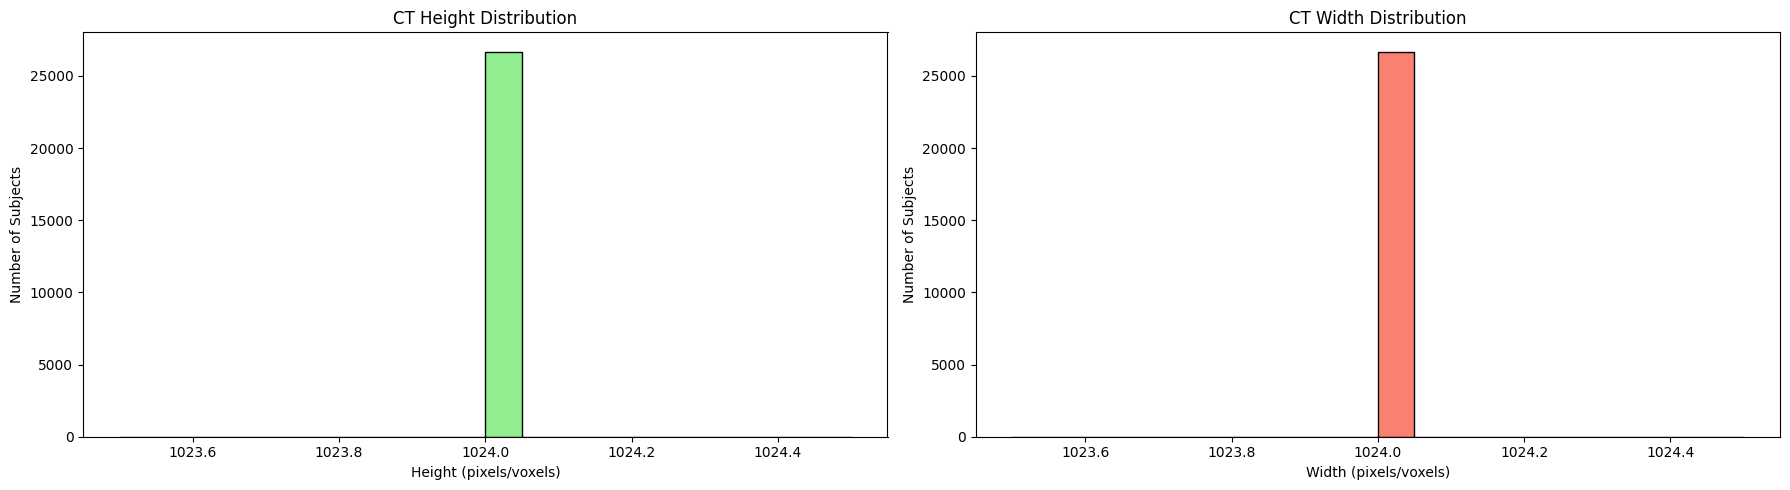

In [10]:
# Plot depth (dimensions)
plt.figure(figsize=(18,5))

# Plot height
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title("CT Height Distribution")
plt.xlabel("Height (pixels/voxels)")
plt.ylabel("Number of Subjects")

# Plot width
plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("CT Width Distribution")
plt.xlabel("Width (pixels/voxels)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()

In [11]:
img_size_og = subjects[15]["CT"].spatial_shape[0]

## **Transforms**

In [12]:
process = tio.Compose([
    tio.ToCanonical(),                        # step 1: fix orientation - RAS              
    tio.RescaleIntensity((0, 1)),                      # step 2: normalize intensity
    tio.Resize((356, 356, 1)),
    tio.CropOrPad((256, 256, 1)),          
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

## **DataSet & DataLoader**

In [13]:
from sklearn.model_selection import train_test_split

# (90/10)
train_val_subjects, test_subjects = train_test_split(
    subjects,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

# (80/20)
train_subjects, val_subjects = train_test_split(
    train_val_subjects,
    test_size=0.2,
    stratify=[s.Label.item() for s in train_val_subjects],
    random_state=42
)

# Verify class distributions
train_labels = [s.Label.item() for s in train_subjects]
val_labels   = [s.Label.item() for s in val_subjects]
test_labels  = [s.Label.item() for s in test_subjects]

print("Train counts:", np.bincount(train_labels))
print("Val counts:", np.bincount(val_labels))
print("Test counts:", np.bincount(test_labels))

Train counts: [14056  4088]
Val counts: [3515 1022]
Test counts: [3101  902]


In [14]:
train_dataset = tio.SubjectsDataset(train_subjects, transform = train_transform) 
val_dataset = tio.SubjectsDataset(val_subjects, transform = val_transform)  
test_dataset = tio.SubjectsDataset(test_subjects, transform = val_transform)  

In [15]:
from typing import Tuple, List

def collate_subjects(batch: List) -> Tuple[torch.Tensor, torch.Tensor]:
    images = torch.stack([s.CT.data.squeeze(-1) for s in batch])
    labels = torch.tensor([s.Label.item() for s in batch])
    return images, labels

In [16]:
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects)

## **TEST DATALOADER SETTINGS**

In [17]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
def measure_dataloader_time(loader, device='cpu'):
    start = time.time()
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Optional: move to GPU if you want to measure transfer
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Do nothing else, just iterate
        pass
    
    end = time.time()
    print(f"Time to iterate through DataLoader: {end - start:.3f} seconds")
    return end - start

In [19]:
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time1 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 616.829 seconds


In [20]:
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects, shuffle=True, pin_memory = True)
time3 = measure_dataloader_time(train_loader, device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Time to iterate through DataLoader: 619.325 seconds


In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time2 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 618.991 seconds


In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time4 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 548.899 seconds


In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time5 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 520.725 seconds


In [24]:
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time6 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 530.864 seconds


In [25]:
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=4, collate_fn=collate_subjects, shuffle=True)
time6 = measure_dataloader_time(train_loader, device)

Time to iterate through DataLoader: 538.863 seconds


In [26]:
# less num_workers = more time taken